----

## Content

### Goal

- Detecting whether a transaction is a normal payment or a fraud.
- '이상치'와 같은 적은 수의 정답 샘플을 가지는 데이터에 대해서 접근하는 법. 
- 많이 접근하는 알고리즘을 비교해보고, 기본적인 접근 원리를 소개. 
- 딥러닝에서 접근하는 Auto Encoder 방법론을 적용해보고, 그 원리와 결과에 대해 해석.
- Auto Encoder 모델에서 베이지안 이론을 적용한 Varaitional Auto Encoder 방법론과 비교.  


### Data
- Data Path
- Basic Analysis
- Feature Engineering

### Model
- AutoEncoder
- Variational AutoEncoder
- IsolationForest

-----

## Data Path

- Read data
- Basic analysis

In [2]:
import pandas as pd
import numpy as np
from collections import Counter

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

In [3]:
train_path = "data/creditcard.csv"

In [4]:
train_data = pd.read_csv(train_path)

In [5]:
train_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
# Data의 개수, 비율 확인, anomaly detection쪽에 가깝다. 
Counter(train_data.Class)

Counter({0: 284315, 1: 492})

In [7]:
normal, fraud = train_data.Class.value_counts().to_numpy()

Fraud Ratio :  0.001727485630620034


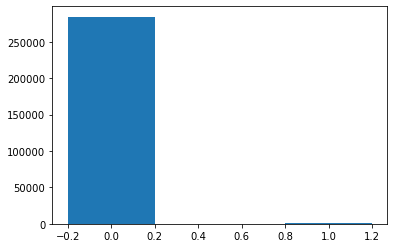

In [8]:
plt.bar([0,1], train_data.Class.value_counts().to_numpy(), width=0.4)
print("Fraud Ratio : ", fraud / (normal+ fraud))

In [9]:
# Column list
# 컬럼 확인. 
np.array(train_data.columns)

array(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9',
       'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18',
       'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27',
       'V28', 'Amount', 'Class'], dtype=object)

In [10]:
# 형태 확인. 
# key-time stamp - other variables.
print(train_data.head())
print(train_data.shape)

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

## Alert data analysis

- 간단한 분석, alert 변수와 다른 변수와의 관계를 살펴보기 위한 간단한 작업. 

<AxesSubplot:>

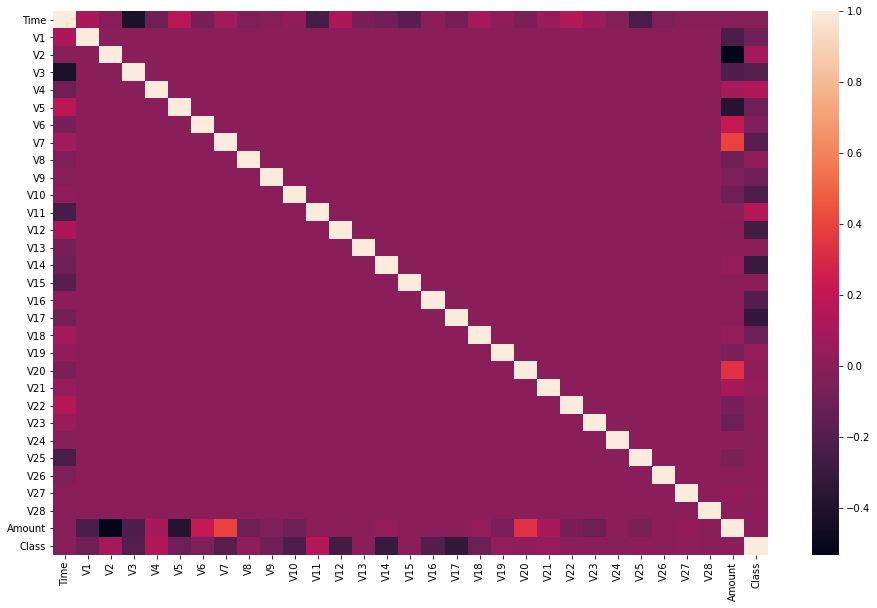

In [11]:
fig, ax = plt.subplots(figsize=(16,10))   
sns.heatmap(train_data.corr(), ax=ax)


In [12]:
train_data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.918649e-15,5.682686e-16,-8.761736e-15,2.811118e-15,-1.552103e-15,2.040130e-15,-1.698953e-15,-1.893285e-16,-3.147640e-15,...,1.473120e-16,8.042109e-16,5.282512e-16,4.456271e-15,1.426896e-15,1.701640e-15,-3.662252e-16,-1.217809e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


array([<AxesSubplot:title={'center':'V6'}>,
       <AxesSubplot:title={'center':'V7'}>,
       <AxesSubplot:title={'center':'V8'}>,
       <AxesSubplot:title={'center':'V9'}>,
       <AxesSubplot:title={'center':'V10'}>,
       <AxesSubplot:title={'center':'V11'}>], dtype=object)

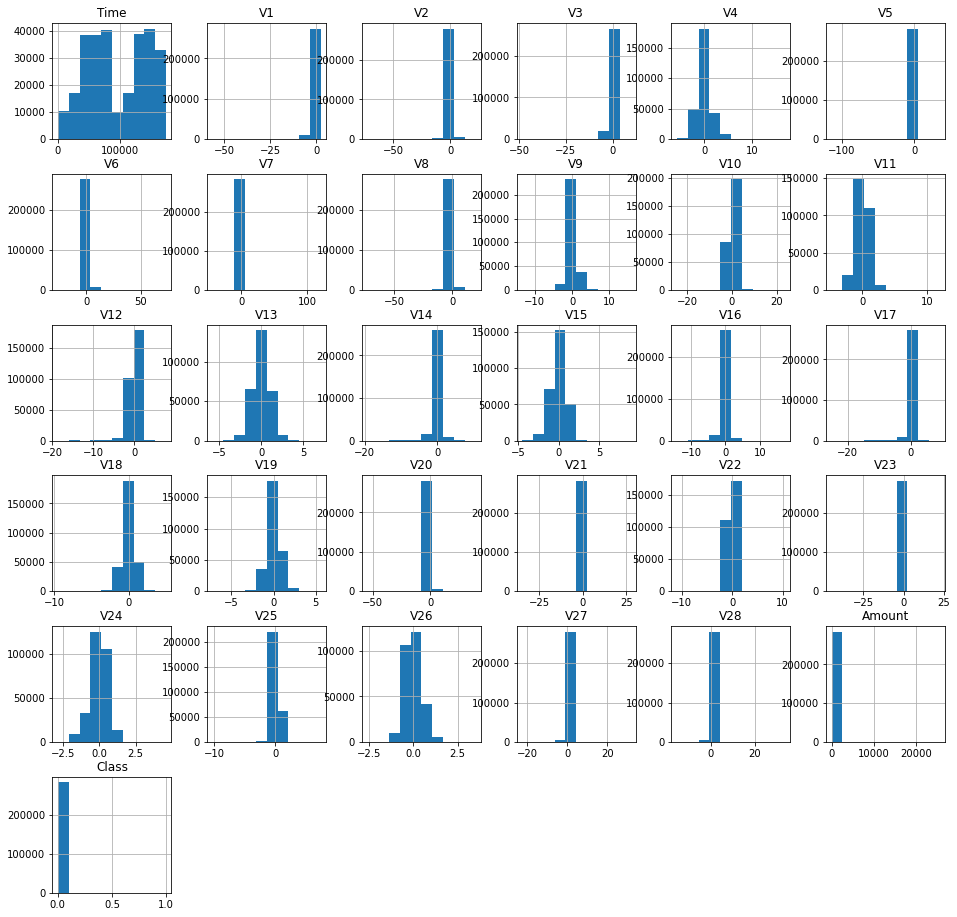

In [13]:
train_data.hist(figsize=(16,16))[1]

------

### 결측치 처리 및 데이터 보완.

- 1) 다른 컬럼들로 채우거나, 수치형 자료의 경우 보간하는 방향. 
- **2) 정확성을 위해 아예 제거하는 방향. (check)**

- 카테고리 변수로 구분 될 수 있는 경우 1, 0 인코딩 하는 방향.
  - XGBoost with category variables 은 성능 향상에 한계가 있었음. 

In [14]:
# 사용자 지정. 
# catetory_columns = []

# creditcard 데이터의 경우, 범주형으로 구분되어 있는 변수가 없기 때문에 수치형 처리나 범주형 속성으로 처리하는 작업 따로 x. 
def make_numerical(df, catetory_columns):
    for item in df.drop(columns=catetory_columns):  
        df[item] = pd.to_numeric(
        df[item], errors="coerce")
    return df 

def make_categorical(df,catetory_columns,debug=False):
    for item in catetory_columns:
        if debug:
            print(item)
            print(df[item].dtype)
        df[item] = df[item].astype("category")
        
    return df 


In [15]:
MODE = "drop" # choice : filling, drop

In [16]:
# 보완 (채우기)
if MODE == "filling":
    train_all = train_data.fillna(method='ffill')
    train_all = train_data.interpolate(method='linear',limit_direction='forward')

# 버리기 
elif MODE == "drop":
    train_all = train_data.dropna()


In [17]:
# 관련이 적은 컬럼 제거.
train_all = train_all.drop(columns=["Time"])

In [18]:
train_all[train_all["Class"] == 1]

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
541,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,-2.772272,...,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1
623,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,-0.838587,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1
4920,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,-1.525412,...,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1
6108,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,-4.801637,...,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,1
6329,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,-2.447469,...,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279863,-1.927883,1.125653,-4.518331,1.749293,-1.566487,-2.010494,-0.882850,0.697211,-2.064945,-5.587794,...,0.778584,-0.319189,0.639419,-0.294885,0.537503,0.788395,0.292680,0.147968,390.00,1
280143,1.378559,1.289381,-5.004247,1.411850,0.442581,-1.326536,-1.413170,0.248525,-1.127396,-3.232153,...,0.370612,0.028234,-0.145640,-0.081049,0.521875,0.739467,0.389152,0.186637,0.76,1
280149,-0.676143,1.126366,-2.213700,0.468308,-1.120541,-0.003346,-2.234739,1.210158,-0.652250,-3.463891,...,0.751826,0.834108,0.190944,0.032070,-0.739695,0.471111,0.385107,0.194361,77.89,1
281144,-3.113832,0.585864,-5.399730,1.817092,-0.840618,-2.943548,-2.208002,1.058733,-1.632333,-5.245984,...,0.583276,-0.269209,-0.456108,-0.183659,-0.328168,0.606116,0.884876,-0.253700,245.00,1


In [19]:
# 최종 사용할 데이터 개수 크기. 
train_all.shape

(284807, 30)

-----
## Split Train and Valid dataset

- 학습할 변수 나눠주기. 

In [105]:
from sklearn.model_selection import train_test_split

def make_split_label(df, debug=False):
    size = int(df.shape[0]* 0.1)
    trainset, validset = train_test_split(df, test_size=size)

    train_data = trainset.iloc[:,:-1]
    train_label = trainset.iloc[:,-1]

    valid_data = validset.iloc[:,:-1]
    valid_label = validset.iloc[:,-1]

    if debug:
        print(Counter(train_label))
        print(Counter(valid_label))

    return train_data,train_label, valid_data, valid_label

def make_split(df, vsize=0.1, tsize=0.15):
    # df : Data Frame 
    vsize = int(df.shape[0]*vsize)
    tsize = int(df.shape[0]*tsize)
    df.sample(frac=1) # shuffle
    trainset, validset, testset = df.iloc[:-(vsize+tsize),:],\
                df.iloc[-(vsize+tsize):-tsize,:], df.iloc[-tsize:,:]
    return trainset, validset,testset

trainset, validset, testset = make_split(train_all)

print(trainset.shape)
print(validset.shape)
print(testset.shape)

assert train_all.shape[0] == (trainset.shape[0] + validset.shape[0] + testset.shape[0])

(213606, 30)
(28480, 30)
(42721, 30)


## Feature engineering

- Small data oversampling or Undersampling datas.
- Could we add supplementary varaibles? 


In [107]:
# Undersampling
trainset = trainset.sample(frac=1)

In [108]:
trainset_undered = pd.concat([trainset[trainset.Class == 0].sample(n=5000), trainset[trainset.Class == 1]])

In [109]:
# Minority 샘플 수를 늘려보기.
from imblearn.over_sampling import SMOTE,ADASYN
from imblearn.over_sampling import BorderlineSMOTE, KMeansSMOTE, SVMSMOTE

In [110]:
SEED = 42

In [112]:
train_samples = trainset_undered.to_numpy()

In [113]:
smote = SMOTE(random_state=SEED)
adasyn = ADASYN(random_state=SEED)
svmsmote = SVMSMOTE(random_state=SEED)
borsmote = BorderlineSMOTE(random_state=SEED)

In [117]:
svmsmote_trainset, svmsmote_trainlabel = svmsmote.fit_resample(train_samples[:,:-1], train_samples[:,-1])

In [118]:
svm_traindata = pd.DataFrame(np.concatenate([svmsmote_trainset, np.expand_dims(svmsmote_trainlabel, axis=1)], axis=1))

In [119]:
# 늘어난 샘플들 형태 확인. 
from sklearn.decomposition import PCA

In [120]:
pca = PCA(n_components=2, n_oversamples=20)

In [121]:
pca_feature = pca.fit_transform(svmsmote_trainset)

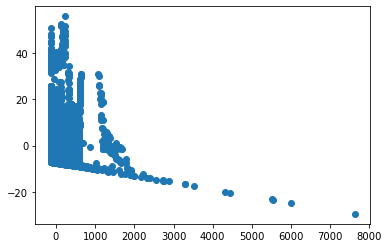

In [122]:
plt.scatter(pca_feature[:,0],pca_feature[:,1]) # Smote 방법론의 한계상, 특정 부분에서 서로 선분 형태로 나타남. 

----

# Modeling

1) XGBoost classifier - categorical variables

2) **Auto Encoder (check)**

3) IsolationForest

## Auto encoder

In [123]:
import random
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from sklearn.metrics import f1_score

In [124]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [125]:
SEED = 42

In [126]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED) # Seed 고정

In [151]:
# Global
EPOCHS = 300
LR = 1e-02
BS = 4096 

In [152]:
class DFDataset(Dataset):
    def __init__(self, df, eval_mode):
        super(DFDataset, self).__init__()
        self.df = df
        self.eval_mode = eval_mode
        if self.eval_mode:
            self.labels = self.df['Class'].values
            self.df = self.df.drop(columns=['Class']).values
        else:
            self.df = self.df.values
        
    def __getitem__(self, index):
        if self.eval_mode:
            self.x = self.df[index]
            self.y = self.labels[index]
            return torch.Tensor(self.x), self.y
        else:
            self.x = self.df[index]
            return torch.Tensor(self.x)
        
    def __len__(self):
        return len(self.df)

## Data selection

In [153]:
DataMode = "svmsmote"

In [154]:
if DataMode == "original":
    train_dataset = DFDataset(df= trainset.drop(columns=['Class']), eval_mode=False)
    train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True, num_workers=6)

    val_dataset = DFDataset(df = validset, eval_mode=True)
    val_loader = DataLoader(val_dataset, batch_size=BS, shuffle=False, num_workers=6)
elif DataMode == "borsmote":
    train_dataset = DFDataset(df= border_traindata.iloc[:,:-1], eval_mode=False)
    train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True, num_workers=6)

    val_dataset = DFDataset(df = validset, eval_mode=True)
    val_loader = DataLoader(val_dataset, batch_size=BS, shuffle=False, num_workers=6)

elif DataMode == "svmsmote":
    train_dataset = DFDataset(df= svm_traindata.iloc[:,:-1], eval_mode=False)
    train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True, num_workers=6)

    val_dataset = DFDataset(df = validset, eval_mode=True)
    val_loader = DataLoader(val_dataset, batch_size=BS, shuffle=False, num_workers=6)
else:
    # custom
    train_dataset = DFDataset(df= svmp_traindata.iloc[:,:-1].astype(np.float32), eval_mode=False)
    train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True, num_workers=6)

    val_dataset = DFDataset(df = pca_validset, eval_mode=True)
    val_loader = DataLoader(val_dataset, batch_size=BS, shuffle=False, num_workers=6)

In [155]:
# Check
train_dataset.df.shape

(10000, 29)

In [156]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.Encoder = nn.Sequential(
            nn.Linear(29,64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Linear(64,128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
        )
        self.Decoder = nn.Sequential(
            nn.Linear(128,64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Linear(64,29),
        )
        
    def forward(self, x):
        x = self.Encoder(x)
        x = self.Decoder(x)
        return x

In [157]:
class Trainer():
    """ Trainer for AE """
    def __init__(self, model, optimizer, train_loader, val_loader, scheduler, device, parallel=False):
        self.model = model
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.scheduler = scheduler
        self.device = device
        self.parallel = parallel
        self.criterion = nn.L1Loss().to(self.device)
#         self.criterion = nn.SmoothL1Loss().to(self.device)
        
    def fit(self, save_pth=""):
        def _msg(ins, outs):
            print(ins, "\n")
            print(outs)
            print("=" * 50)
            
        self.model.to(self.device)
        best_score = 0
        for ind, epoch in enumerate(range(EPOCHS)):
            self.model.train()
            train_loss = []
            for x in iter(self.train_loader):
                x = x.float().to(self.device)    
                self.optimizer.zero_grad()
                _x = self.model(x)

                loss = self.criterion(x, _x)
                loss.backward()
                self.optimizer.step()
                train_loss.append(loss.item())
            

            score = self.validation(0.95)
            print(f'Epoch : [{epoch}] Train loss : [{np.mean(train_loss)}] Val f1 : [{score}])')

            if self.scheduler is not None:
                self.scheduler.step(score)

            if best_score < score:
                best_score = score
                if self.parallel:
                    torch.save(model.module.state_dict(), \
                               save_pth,\
                                _use_new_zipfile_serialization=False)
                    
                torch.save(self.model, save_pth)
    
    def validation(self,thr):
        cos = nn.CosineSimilarity(dim=1, eps=1e-6)
        self.model.eval()
        pred = []
        true = []
        with torch.no_grad():
            for x, y in iter(self.val_loader):
                x = x.float().to(self.device)
                _x = self.model(x)
                diff = cos(x, _x).cpu().tolist()
                batch_pred = np.where(np.array(diff)<thr, 1, 0).tolist()
                pred += batch_pred
                true += y.tolist()

        return f1_score(true, pred, average='macro')

In [158]:
SAVE_DIR = "result"

In [159]:
if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

In [160]:
save_pth = SAVE_DIR+"/model.pt"

In [161]:
model = AutoEncoder()

optimizer = torch.optim.Adam(params = model.parameters(), lr = LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, threshold_mode='abs', min_lr=1e-8, verbose=True)

trainer = Trainer(model, optimizer, train_loader, val_loader, scheduler, device)
trainer.fit(save_pth=save_pth)

Epoch : [0] Train loss : [6.157745361328125] Val f1 : [0.001577563540753725])
Epoch : [1] Train loss : [5.9151387214660645] Val f1 : [0.001577563540753725])
Epoch : [2] Train loss : [5.600389003753662] Val f1 : [0.0015075553062440835])
Epoch : [3] Train loss : [5.5916469891866045] Val f1 : [0.0014025245441795233])
Epoch : [4] Train loss : [5.422787030537923] Val f1 : [0.0014025245441795233])
Epoch : [5] Train loss : [5.4787600835164385] Val f1 : [0.001472547507187434])
Epoch : [6] Train loss : [5.374310652414958] Val f1 : [0.0015429742594335063])
Epoch : [7] Train loss : [5.276621659596761] Val f1 : [0.020803629031098364])
Epoch : [8] Train loss : [5.327137629191081] Val f1 : [0.12282071006207079])
Epoch : [9] Train loss : [5.241098403930664] Val f1 : [0.1515911051704066])
Epoch : [10] Train loss : [5.237446943918864] Val f1 : [0.1998715002337865])
Epoch : [11] Train loss : [5.226737817128499] Val f1 : [0.2370587782125464])
Epoch : [12] Train loss : [5.092943827311198] Val f1 : [0.2712

Epoch : [105] Train loss : [0.6696408788363138] Val f1 : [0.4050444197669542])
Epoch : [106] Train loss : [0.7460048993428549] Val f1 : [0.4045401445238594])
Epoch : [107] Train loss : [0.6609712243080139] Val f1 : [0.4051993260160522])
Epoch : [108] Train loss : [0.6420682271321615] Val f1 : [0.40318848583649847])
Epoch : [109] Train loss : [0.6791153152783712] Val f1 : [0.4055269498579939])
Epoch : [110] Train loss : [0.8834685683250427] Val f1 : [0.40465675323306793])
Epoch : [111] Train loss : [0.7110891143480936] Val f1 : [0.4043914427842864])
Epoch : [112] Train loss : [0.6185450951258341] Val f1 : [0.4029606964277872])
Epoch : [113] Train loss : [0.7757006883621216] Val f1 : [0.4059215775731148])
Epoch : [114] Train loss : [0.7130493323008219] Val f1 : [0.40559820459402396])
Epoch : [115] Train loss : [0.707170565923055] Val f1 : [0.40593417300493])
Epoch : [116] Train loss : [0.7891884048779806] Val f1 : [0.4050007861529493])
Epoch : [117] Train loss : [0.679070790608724] Val f

Epoch : [207] Train loss : [0.5259954531987509] Val f1 : [0.4140114033961163])
Epoch : [208] Train loss : [0.6915495196978251] Val f1 : [0.4142969486817511])
Epoch : [209] Train loss : [0.5104185740152994] Val f1 : [0.41444331900246056])
Epoch : [210] Train loss : [0.6440900365511576] Val f1 : [0.41458962151316653])
Epoch : [211] Train loss : [0.7106164693832397] Val f1 : [0.41436478323216314])
Epoch : [212] Train loss : [0.5603532095750173] Val f1 : [0.41433354762292735])
Epoch : [213] Train loss : [0.6109471718470255] Val f1 : [0.4141505104813635])
Epoch : [214] Train loss : [0.6617361704508463] Val f1 : [0.41405284726911773])
Epoch : [215] Train loss : [0.5902556578318278] Val f1 : [0.4142429732023054])
Epoch : [216] Train loss : [0.6510178446769714] Val f1 : [0.4143769616270579])
Epoch : [217] Train loss : [0.5122385323047638] Val f1 : [0.4144378464916871])
Epoch : [218] Train loss : [0.5709348519643148] Val f1 : [0.4142969486817511])
Epoch : [219] Train loss : [0.657773494720459] 

# Test 

In [149]:
test_data = pd.read_csv(test_path)

In [150]:
test_model = torch.load('result/model.pt')

In [151]:
test_model.eval()

AutoEncoder(
  (Encoder): Sequential(
    (0): Linear(in_features=14, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=64, out_features=128, bias=True)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
  )
  (Decoder): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=64, out_features=14, bias=True)
  )
)

In [156]:
Flag = False

In [159]:
if Flag:
    test_dataset = DFDataset(pca_testset, False)
    test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False, num_workers=6)
else:
    test_dataset = DFDataset(test_in, False)
    test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False, num_workers=6)
    
def prediction(model, thr, test_loader, device):
    model.to(device)
    model.eval()
    cos = nn.CosineSimilarity(dim=1, eps=1e-6)
    pred = []
    with torch.no_grad():
        for x in iter(test_loader):
            x = x.float().to(device)
            _x = model(x)
            
            diff = cos(x, _x).cpu().tolist()
            batch_pred = np.where(np.array(diff)<thr, 1,0).tolist()
            pred += batch_pred
    return pred


In [160]:
thres = 0.95

In [161]:
pred = prediction(test_model, thres , test_loader, device)

In [162]:
label = pd.DataFrame(pred)

In [163]:
example_df = pd.read_csv("./example.csv")
example_df["alert"] = label

# Check
print(Counter(example_df.alert))


Counter({0: 6636, 1: 493})


In [164]:

# Test file write
example_df.to_csv("result/test_result.csv", index=False) # 0.57